In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import argparse
import os

import numpy as np
np.random.seed(2016)
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import list_pictures, array_to_img
 

Using TensorFlow backend.


In [2]:
def create_fcn(input_size):
    inputs = Input((3, input_size[1], input_size[0]))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same', data_format='channels_first')(pool5)
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv6), conv5])
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv7), conv4])
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv8), conv3])
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv9)

    up10 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv9), conv2])
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv10)

    up11 = Concatenate(axis=1)([UpSampling2D(size=(2, 2), data_format='channels_first')(conv10), conv1])
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_first')(conv11)

    conv12 = Conv2D(1, (1, 1), activation='sigmoid', data_format='channels_first')(conv11)
    #conv12 = Conv2D(1, 1, 1)(conv11)
    
    fcn = Model(input=inputs, output=conv12)

    return fcn

In [3]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

In [4]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
if __name__ == '__main__':

    from image_ext import list_pictures_in_multidir, load_imgs_asarray  
    
    fpaths_xs_train = list_pictures_in_multidir(['./dataset/train/image/', 
                                                 './dataset/train/image-aug3/'])
    fpaths_ys_train = list_pictures_in_multidir(['./dataset/train/gt/', 
                                                 './dataset/train/gt-aug3/'])
    fpaths_xs_valid = list_pictures_in_multidir(['./dataset/valid/image/', 
                                                 './dataset/valid/image-aug3/'])
    fpaths_ys_valid = list_pictures_in_multidir(['./dataset/valid/gt/', 
                                                 './dataset/valid/gt-aug3/'])
#    fpaths_xs_train = list_pictures_in_multidir(['./data-scene/train/', 
#                                                 './data-scene/train-aug/'])
#    fpaths_ys_train = list_pictures_in_multidir(['./data-scene/train_mask/', 
#                                                 './data-scene/train_mask-aug/'])
#    fpaths_xs_valid = list_pictures_in_multidir(['./data-scene/valid/', 
#                                                 './data-scene/valid-aug'])
#    fpaths_ys_valid = list_pictures_in_multidir(['./data-scene/valid_mask', 
#                                                 './data-scene/valid_mask-aug/'])
    
    #dim_ordering ='tf' 
    dim_ordering = 'channels_first'
    target_size = (224, 224)
    
    # データを配列として取得
    print('loading data...')
    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, 
                                target_size=target_size, dim_ordering=dim_ordering)
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, 
                                target_size=target_size, dim_ordering=dim_ordering)
    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False,
                                target_size=target_size, dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True,
                                target_size=target_size, dim_ordering=dim_ordering)
    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')    

['./dataset/train/image-aug3/00000.jpg', './dataset/train/image-aug3/00001.jpg', './dataset/train/image-aug3/00002.jpg', './dataset/train/image-aug3/00003.jpg', './dataset/train/image-aug3/00004.jpg', './dataset/train/image-aug3/00005.jpg', './dataset/train/image-aug3/00006.jpg', './dataset/train/image-aug3/00007.jpg', './dataset/train/image-aug3/00008.jpg', './dataset/train/image-aug3/00009.jpg', './dataset/train/image-aug3/00010.jpg', './dataset/train/image-aug3/00011.jpg', './dataset/train/image-aug3/00012.jpg', './dataset/train/image-aug3/00013.jpg', './dataset/train/image-aug3/00014.jpg', './dataset/train/image-aug3/00015.jpg', './dataset/train/image-aug3/00016.jpg', './dataset/train/image-aug3/00017.jpg', './dataset/train/image-aug3/00018.jpg', './dataset/train/image-aug3/00019.jpg', './dataset/train/image-aug3/00020.jpg', './dataset/train/image-aug3/00021.jpg', './dataset/train/image-aug3/00022.jpg', './dataset/train/image-aug3/00023.jpg', './dataset/train/image-aug3/00024.jpg',

['./dataset/valid/gt-aug3/00000.jpg', './dataset/valid/gt-aug3/00001.jpg', './dataset/valid/gt-aug3/00002.jpg', './dataset/valid/gt-aug3/00003.jpg', './dataset/valid/gt-aug3/00004.jpg', './dataset/valid/gt-aug3/00005.jpg', './dataset/valid/gt-aug3/00006.jpg', './dataset/valid/gt-aug3/00007.jpg', './dataset/valid/gt-aug3/00008.jpg', './dataset/valid/gt-aug3/00009.jpg', './dataset/valid/gt-aug3/00010.jpg', './dataset/valid/gt-aug3/00011.jpg', './dataset/valid/gt-aug3/00012.jpg', './dataset/valid/gt-aug3/00013.jpg', './dataset/valid/gt-aug3/00014.jpg', './dataset/valid/gt-aug3/00015.jpg', './dataset/valid/gt-aug3/00016.jpg', './dataset/valid/gt-aug3/00017.jpg', './dataset/valid/gt-aug3/00018.jpg', './dataset/valid/gt-aug3/00019.jpg', './dataset/valid/gt-aug3/00020.jpg', './dataset/valid/gt-aug3/00021.jpg', './dataset/valid/gt-aug3/00022.jpg', './dataset/valid/gt-aug3/00023.jpg', './dataset/valid/gt-aug3/00024.jpg', './dataset/valid/gt-aug3/00025.jpg', './dataset/valid/gt-aug3/00026.jpg', 

./dataset/train/image-aug3/00023.jpg
./dataset/train/image-aug3/00024.jpg
./dataset/train/image-aug3/00025.jpg
./dataset/train/image-aug3/00026.jpg
./dataset/train/image-aug3/00027.jpg
./dataset/train/image-aug3/00028.jpg
./dataset/train/image-aug3/00029.jpg
./dataset/train/image-aug3/00030.jpg
./dataset/train/image-aug3/00031.jpg
./dataset/train/image-aug3/00032.jpg
./dataset/train/image-aug3/00033.jpg
./dataset/train/image-aug3/00034.jpg
./dataset/train/image-aug3/00035.jpg
./dataset/train/image-aug3/00036.jpg
./dataset/train/image-aug3/00037.jpg
./dataset/train/image-aug3/00038.jpg
./dataset/train/image-aug3/00039.jpg
./dataset/train/image-aug3/00040.jpg
./dataset/train/image-aug3/00041.jpg
./dataset/train/image-aug3/00042.jpg
./dataset/train/image-aug3/00043.jpg
./dataset/train/image-aug3/00044.jpg
./dataset/train/image-aug3/00045.jpg
./dataset/train/image-aug3/00046.jpg
./dataset/train/image-aug3/00047.jpg
./dataset/train/image-aug3/00048.jpg
./dataset/train/image-aug3/00049.jpg
.

./dataset/train/image-aug3/00306.jpg
./dataset/train/image-aug3/00307.jpg
./dataset/train/image-aug3/00308.jpg
./dataset/train/image-aug3/00309.jpg
./dataset/train/image-aug3/00310.jpg
./dataset/train/image-aug3/00311.jpg
./dataset/train/image-aug3/00312.jpg
./dataset/train/image-aug3/00313.jpg
./dataset/train/image-aug3/00314.jpg
./dataset/train/image-aug3/00315.jpg
./dataset/train/image-aug3/00316.jpg
./dataset/train/image-aug3/00317.jpg
./dataset/train/image-aug3/00318.jpg
./dataset/train/image-aug3/00319.jpg
./dataset/train/image-aug3/00320.jpg
./dataset/train/image-aug3/00321.jpg
./dataset/train/image-aug3/00322.jpg
./dataset/train/image-aug3/00323.jpg
./dataset/train/image-aug3/00324.jpg
./dataset/train/image-aug3/00325.jpg
./dataset/train/image-aug3/00326.jpg
./dataset/train/image-aug3/00327.jpg
./dataset/train/image-aug3/00328.jpg
./dataset/train/image-aug3/00329.jpg
./dataset/train/image-aug3/00330.jpg
./dataset/train/image-aug3/00331.jpg
./dataset/train/image-aug3/00332.jpg
.

./dataset/train/image-aug3/00542.jpg
./dataset/train/image-aug3/00543.jpg
./dataset/train/image-aug3/00544.jpg
./dataset/train/image-aug3/00545.jpg
./dataset/train/image-aug3/00546.jpg
./dataset/train/image-aug3/00547.jpg
./dataset/train/image-aug3/00548.jpg
./dataset/train/image-aug3/00549.jpg
./dataset/train/image-aug3/00550.jpg
./dataset/train/image-aug3/00551.jpg
./dataset/train/image-aug3/00552.jpg
./dataset/train/image-aug3/00553.jpg
./dataset/train/image-aug3/00554.jpg
./dataset/train/image-aug3/00555.jpg
./dataset/train/image-aug3/00556.jpg
./dataset/train/image-aug3/00557.jpg
./dataset/train/image-aug3/00558.jpg
./dataset/train/image-aug3/00559.jpg
./dataset/train/image-aug3/00560.jpg
./dataset/train/image-aug3/00561.jpg
./dataset/train/image-aug3/00562.jpg
./dataset/train/image-aug3/00563.jpg
./dataset/train/image-aug3/00564.jpg
./dataset/train/image-aug3/00565.jpg
./dataset/train/image-aug3/00566.jpg
./dataset/train/image-aug3/00567.jpg
./dataset/train/image-aug3/00568.jpg
.

./dataset/train/image-aug3/00782.jpg
./dataset/train/image-aug3/00783.jpg
./dataset/train/image-aug3/00784.jpg
./dataset/train/image-aug3/00785.jpg
./dataset/train/image-aug3/00786.jpg
./dataset/train/image-aug3/00787.jpg
./dataset/train/image-aug3/00788.jpg
./dataset/train/image-aug3/00789.jpg
./dataset/train/image-aug3/00790.jpg
./dataset/train/image-aug3/00791.jpg
./dataset/train/image-aug3/00792.jpg
./dataset/train/image-aug3/00793.jpg
./dataset/train/image-aug3/00794.jpg
./dataset/train/image-aug3/00795.jpg
./dataset/train/image-aug3/00796.jpg
./dataset/train/image-aug3/00797.jpg
./dataset/train/image-aug3/00798.jpg
./dataset/train/image-aug3/00799.jpg
./dataset/train/image-aug3/00800.jpg
./dataset/train/image-aug3/00801.jpg
./dataset/train/image-aug3/00802.jpg
./dataset/train/image-aug3/00803.jpg
./dataset/train/image-aug3/00804.jpg
./dataset/train/image-aug3/00805.jpg
./dataset/train/image-aug3/00806.jpg
./dataset/train/image-aug3/00807.jpg
./dataset/train/image-aug3/00808.jpg
.

./dataset/train/image-aug3/01016.jpg
./dataset/train/image-aug3/01017.jpg
./dataset/train/image-aug3/01018.jpg
./dataset/train/image-aug3/01019.jpg
./dataset/train/image-aug3/01020.jpg
./dataset/train/image-aug3/01021.jpg
./dataset/train/image-aug3/01022.jpg
./dataset/train/image-aug3/01023.jpg
./dataset/train/image-aug3/01024.jpg
./dataset/train/image-aug3/01025.jpg
./dataset/train/image-aug3/01026.jpg
./dataset/train/image-aug3/01027.jpg
./dataset/train/image-aug3/01028.jpg
./dataset/train/image-aug3/01029.jpg
./dataset/train/image-aug3/01030.jpg
./dataset/train/image-aug3/01031.jpg
./dataset/train/image-aug3/01032.jpg
./dataset/train/image-aug3/01033.jpg
./dataset/train/image-aug3/01034.jpg
./dataset/train/image-aug3/01035.jpg
./dataset/train/image-aug3/01036.jpg
./dataset/train/image-aug3/01037.jpg
./dataset/train/image-aug3/01038.jpg
./dataset/train/image-aug3/01039.jpg
./dataset/train/image-aug3/01040.jpg
./dataset/train/image-aug3/01041.jpg
./dataset/train/image-aug3/01042.jpg
.

./dataset/train/image-aug3/01292.jpg
./dataset/train/image-aug3/01293.jpg
./dataset/train/image-aug3/01294.jpg
./dataset/train/image-aug3/01295.jpg
./dataset/train/image-aug3/01296.jpg
./dataset/train/image-aug3/01297.jpg
./dataset/train/image-aug3/01298.jpg
./dataset/train/image-aug3/01299.jpg
./dataset/train/image-aug3/01300.jpg
./dataset/train/image-aug3/01301.jpg
./dataset/train/image-aug3/01302.jpg
./dataset/train/image-aug3/01303.jpg
./dataset/train/image-aug3/01304.jpg
./dataset/train/image-aug3/01305.jpg
./dataset/train/image-aug3/01306.jpg
./dataset/train/image-aug3/01307.jpg
./dataset/train/image-aug3/01308.jpg
./dataset/train/image-aug3/01309.jpg
./dataset/train/image-aug3/01310.jpg
./dataset/train/image-aug3/01311.jpg
./dataset/train/image-aug3/01312.jpg
./dataset/train/image-aug3/01313.jpg
./dataset/train/image-aug3/01314.jpg
./dataset/train/image-aug3/01315.jpg
./dataset/train/image-aug3/01316.jpg
./dataset/train/image-aug3/01317.jpg
./dataset/train/image-aug3/01318.jpg
.

./dataset/train/image-aug3/01533.jpg
./dataset/train/image-aug3/01534.jpg
./dataset/train/image-aug3/01535.jpg
./dataset/train/image-aug3/01536.jpg
./dataset/train/image-aug3/01537.jpg
./dataset/train/image-aug3/01538.jpg
./dataset/train/image-aug3/01539.jpg
./dataset/train/image-aug3/01540.jpg
./dataset/train/image-aug3/01541.jpg
./dataset/train/image-aug3/01542.jpg
./dataset/train/image-aug3/01543.jpg
./dataset/train/image-aug3/01544.jpg
./dataset/train/image-aug3/01545.jpg
./dataset/train/image-aug3/01546.jpg
./dataset/train/image-aug3/01547.jpg
./dataset/train/image-aug3/01548.jpg
./dataset/train/image-aug3/01549.jpg
./dataset/train/image-aug3/01550.jpg
./dataset/train/image-aug3/01551.jpg
./dataset/train/image-aug3/01552.jpg
./dataset/train/image-aug3/01553.jpg
./dataset/train/image-aug3/01554.jpg
./dataset/train/image-aug3/01555.jpg
./dataset/train/image-aug3/01556.jpg
./dataset/train/image-aug3/01557.jpg
./dataset/train/image-aug3/01558.jpg
./dataset/train/image-aug3/01559.jpg
.

./dataset/train/image-aug3/01797.jpg
./dataset/train/image-aug3/01798.jpg
./dataset/train/image-aug3/01799.jpg
./dataset/train/image-aug3/01800.jpg
./dataset/train/image-aug3/01801.jpg
./dataset/train/image-aug3/01802.jpg
./dataset/train/image-aug3/01803.jpg
./dataset/train/image-aug3/01804.jpg
./dataset/train/image-aug3/01805.jpg
./dataset/train/image-aug3/01806.jpg
./dataset/train/image-aug3/01807.jpg
./dataset/train/image-aug3/01808.jpg
./dataset/train/image-aug3/01809.jpg
./dataset/train/image-aug3/01810.jpg
./dataset/train/image-aug3/01811.jpg
./dataset/train/image-aug3/01812.jpg
./dataset/train/image-aug3/01813.jpg
./dataset/train/image-aug3/01814.jpg
./dataset/train/image-aug3/01815.jpg
./dataset/train/image-aug3/01816.jpg
./dataset/train/image-aug3/01817.jpg
./dataset/train/image-aug3/01818.jpg
./dataset/train/image-aug3/01819.jpg
./dataset/train/image-aug3/01820.jpg
./dataset/train/image-aug3/01821.jpg
./dataset/train/image-aug3/01822.jpg
./dataset/train/image-aug3/01823.jpg
.

./dataset/train/image/higuchi0679.png
./dataset/train/image/higuchi0727.png
./dataset/train/image/higuchi0762.png
./dataset/train/image/higuchi0862.png
./dataset/train/image/kitazumi0054.png
./dataset/train/image/kitazumi0163.png
./dataset/train/image/kitazumi0231.png
./dataset/train/image/kitazumi0270.png
./dataset/train/image/kitazumi0367.png
./dataset/train/image/kitazumi0415.png
./dataset/train/image/kitazumi0443.png
./dataset/train/image/kitazumi0507.png
./dataset/train/image/kitazumi0578.png
./dataset/train/image/kitazumi0670.png
./dataset/train/image/kitazumi0685.png
./dataset/train/image/kitazumi0786.png
./dataset/train/image/matsuda0090.png
./dataset/train/image/matsuda0114.png
./dataset/train/image/matsuda0238.png
./dataset/train/image/matsuda0266.png
./dataset/train/image/matsuda0310.png
./dataset/train/image/matsuda0382.png
./dataset/train/image/matsuda0431.png
./dataset/train/image/matsuda0499.png
./dataset/train/image/matsuda0559.png
./dataset/train/image/matsuda0634.png


./dataset/train/gt-aug3/00197.jpg
./dataset/train/gt-aug3/00198.jpg
./dataset/train/gt-aug3/00199.jpg
./dataset/train/gt-aug3/00200.jpg
./dataset/train/gt-aug3/00201.jpg
./dataset/train/gt-aug3/00202.jpg
./dataset/train/gt-aug3/00203.jpg
./dataset/train/gt-aug3/00204.jpg
./dataset/train/gt-aug3/00205.jpg
./dataset/train/gt-aug3/00206.jpg
./dataset/train/gt-aug3/00207.jpg
./dataset/train/gt-aug3/00208.jpg
./dataset/train/gt-aug3/00209.jpg
./dataset/train/gt-aug3/00210.jpg
./dataset/train/gt-aug3/00211.jpg
./dataset/train/gt-aug3/00212.jpg
./dataset/train/gt-aug3/00213.jpg
./dataset/train/gt-aug3/00214.jpg
./dataset/train/gt-aug3/00215.jpg
./dataset/train/gt-aug3/00216.jpg
./dataset/train/gt-aug3/00217.jpg
./dataset/train/gt-aug3/00218.jpg
./dataset/train/gt-aug3/00219.jpg
./dataset/train/gt-aug3/00220.jpg
./dataset/train/gt-aug3/00221.jpg
./dataset/train/gt-aug3/00222.jpg
./dataset/train/gt-aug3/00223.jpg
./dataset/train/gt-aug3/00224.jpg
./dataset/train/gt-aug3/00225.jpg
./dataset/trai

./dataset/train/gt-aug3/00487.jpg
./dataset/train/gt-aug3/00488.jpg
./dataset/train/gt-aug3/00489.jpg
./dataset/train/gt-aug3/00490.jpg
./dataset/train/gt-aug3/00491.jpg
./dataset/train/gt-aug3/00492.jpg
./dataset/train/gt-aug3/00493.jpg
./dataset/train/gt-aug3/00494.jpg
./dataset/train/gt-aug3/00495.jpg
./dataset/train/gt-aug3/00496.jpg
./dataset/train/gt-aug3/00497.jpg
./dataset/train/gt-aug3/00498.jpg
./dataset/train/gt-aug3/00499.jpg
./dataset/train/gt-aug3/00500.jpg
./dataset/train/gt-aug3/00501.jpg
./dataset/train/gt-aug3/00502.jpg
./dataset/train/gt-aug3/00503.jpg
./dataset/train/gt-aug3/00504.jpg
./dataset/train/gt-aug3/00505.jpg
./dataset/train/gt-aug3/00506.jpg
./dataset/train/gt-aug3/00507.jpg
./dataset/train/gt-aug3/00508.jpg
./dataset/train/gt-aug3/00509.jpg
./dataset/train/gt-aug3/00510.jpg
./dataset/train/gt-aug3/00511.jpg
./dataset/train/gt-aug3/00512.jpg
./dataset/train/gt-aug3/00513.jpg
./dataset/train/gt-aug3/00514.jpg
./dataset/train/gt-aug3/00515.jpg
./dataset/trai

./dataset/train/gt-aug3/00784.jpg
./dataset/train/gt-aug3/00785.jpg
./dataset/train/gt-aug3/00786.jpg
./dataset/train/gt-aug3/00787.jpg
./dataset/train/gt-aug3/00788.jpg
./dataset/train/gt-aug3/00789.jpg
./dataset/train/gt-aug3/00790.jpg
./dataset/train/gt-aug3/00791.jpg
./dataset/train/gt-aug3/00792.jpg
./dataset/train/gt-aug3/00793.jpg
./dataset/train/gt-aug3/00794.jpg
./dataset/train/gt-aug3/00795.jpg
./dataset/train/gt-aug3/00796.jpg
./dataset/train/gt-aug3/00797.jpg
./dataset/train/gt-aug3/00798.jpg
./dataset/train/gt-aug3/00799.jpg
./dataset/train/gt-aug3/00800.jpg
./dataset/train/gt-aug3/00801.jpg
./dataset/train/gt-aug3/00802.jpg
./dataset/train/gt-aug3/00803.jpg
./dataset/train/gt-aug3/00804.jpg
./dataset/train/gt-aug3/00805.jpg
./dataset/train/gt-aug3/00806.jpg
./dataset/train/gt-aug3/00807.jpg
./dataset/train/gt-aug3/00808.jpg
./dataset/train/gt-aug3/00809.jpg
./dataset/train/gt-aug3/00810.jpg
./dataset/train/gt-aug3/00811.jpg
./dataset/train/gt-aug3/00812.jpg
./dataset/trai

./dataset/train/gt-aug3/01061.jpg
./dataset/train/gt-aug3/01062.jpg
./dataset/train/gt-aug3/01063.jpg
./dataset/train/gt-aug3/01064.jpg
./dataset/train/gt-aug3/01065.jpg
./dataset/train/gt-aug3/01066.jpg
./dataset/train/gt-aug3/01067.jpg
./dataset/train/gt-aug3/01068.jpg
./dataset/train/gt-aug3/01069.jpg
./dataset/train/gt-aug3/01070.jpg
./dataset/train/gt-aug3/01071.jpg
./dataset/train/gt-aug3/01072.jpg
./dataset/train/gt-aug3/01073.jpg
./dataset/train/gt-aug3/01074.jpg
./dataset/train/gt-aug3/01075.jpg
./dataset/train/gt-aug3/01076.jpg
./dataset/train/gt-aug3/01077.jpg
./dataset/train/gt-aug3/01078.jpg
./dataset/train/gt-aug3/01079.jpg
./dataset/train/gt-aug3/01080.jpg
./dataset/train/gt-aug3/01081.jpg
./dataset/train/gt-aug3/01082.jpg
./dataset/train/gt-aug3/01083.jpg
./dataset/train/gt-aug3/01084.jpg
./dataset/train/gt-aug3/01085.jpg
./dataset/train/gt-aug3/01086.jpg
./dataset/train/gt-aug3/01087.jpg
./dataset/train/gt-aug3/01088.jpg
./dataset/train/gt-aug3/01089.jpg
./dataset/trai

./dataset/train/gt-aug3/01308.jpg
./dataset/train/gt-aug3/01309.jpg
./dataset/train/gt-aug3/01310.jpg
./dataset/train/gt-aug3/01311.jpg
./dataset/train/gt-aug3/01312.jpg
./dataset/train/gt-aug3/01313.jpg
./dataset/train/gt-aug3/01314.jpg
./dataset/train/gt-aug3/01315.jpg
./dataset/train/gt-aug3/01316.jpg
./dataset/train/gt-aug3/01317.jpg
./dataset/train/gt-aug3/01318.jpg
./dataset/train/gt-aug3/01319.jpg
./dataset/train/gt-aug3/01320.jpg
./dataset/train/gt-aug3/01321.jpg
./dataset/train/gt-aug3/01322.jpg
./dataset/train/gt-aug3/01323.jpg
./dataset/train/gt-aug3/01324.jpg
./dataset/train/gt-aug3/01325.jpg
./dataset/train/gt-aug3/01326.jpg
./dataset/train/gt-aug3/01327.jpg
./dataset/train/gt-aug3/01328.jpg
./dataset/train/gt-aug3/01329.jpg
./dataset/train/gt-aug3/01330.jpg
./dataset/train/gt-aug3/01331.jpg
./dataset/train/gt-aug3/01332.jpg
./dataset/train/gt-aug3/01333.jpg
./dataset/train/gt-aug3/01334.jpg
./dataset/train/gt-aug3/01335.jpg
./dataset/train/gt-aug3/01336.jpg
./dataset/trai

./dataset/train/gt-aug3/01569.jpg
./dataset/train/gt-aug3/01570.jpg
./dataset/train/gt-aug3/01571.jpg
./dataset/train/gt-aug3/01572.jpg
./dataset/train/gt-aug3/01573.jpg
./dataset/train/gt-aug3/01574.jpg
./dataset/train/gt-aug3/01575.jpg
./dataset/train/gt-aug3/01576.jpg
./dataset/train/gt-aug3/01577.jpg
./dataset/train/gt-aug3/01578.jpg
./dataset/train/gt-aug3/01579.jpg
./dataset/train/gt-aug3/01580.jpg
./dataset/train/gt-aug3/01581.jpg
./dataset/train/gt-aug3/01582.jpg
./dataset/train/gt-aug3/01583.jpg
./dataset/train/gt-aug3/01584.jpg
./dataset/train/gt-aug3/01585.jpg
./dataset/train/gt-aug3/01586.jpg
./dataset/train/gt-aug3/01587.jpg
./dataset/train/gt-aug3/01588.jpg
./dataset/train/gt-aug3/01589.jpg
./dataset/train/gt-aug3/01590.jpg
./dataset/train/gt-aug3/01591.jpg
./dataset/train/gt-aug3/01592.jpg
./dataset/train/gt-aug3/01593.jpg
./dataset/train/gt-aug3/01594.jpg
./dataset/train/gt-aug3/01595.jpg
./dataset/train/gt-aug3/01596.jpg
./dataset/train/gt-aug3/01597.jpg
./dataset/trai

./dataset/train/gt-aug3/01832.jpg
./dataset/train/gt-aug3/01833.jpg
./dataset/train/gt-aug3/01834.jpg
./dataset/train/gt-aug3/01835.jpg
./dataset/train/gt-aug3/01836.jpg
./dataset/train/gt-aug3/01837.jpg
./dataset/train/gt-aug3/01838.jpg
./dataset/train/gt-aug3/01839.jpg
./dataset/train/gt-aug3/01840.jpg
./dataset/train/gt-aug3/01841.jpg
./dataset/train/gt-aug3/01842.jpg
./dataset/train/gt-aug3/01843.jpg
./dataset/train/gt-aug3/01844.jpg
./dataset/train/gt-aug3/01845.jpg
./dataset/train/gt-aug3/01846.jpg
./dataset/train/gt-aug3/01847.jpg
./dataset/train/gt-aug3/01848.jpg
./dataset/train/gt-aug3/01849.jpg
./dataset/train/gt-aug3/01850.jpg
./dataset/train/gt-aug3/01851.jpg
./dataset/train/gt-aug3/01852.jpg
./dataset/train/gt-aug3/01853.jpg
./dataset/train/gt-aug3/01854.jpg
./dataset/train/gt-aug3/01855.jpg
./dataset/train/gt-aug3/01856.jpg
./dataset/train/gt-aug3/01857.jpg
./dataset/train/gt-aug3/01858.jpg
./dataset/train/gt-aug3/01859.jpg
./dataset/train/gt-aug3/01860.jpg
./dataset/trai

./dataset/valid/image-aug3/00000.jpg
./dataset/valid/image-aug3/00001.jpg
./dataset/valid/image-aug3/00002.jpg
./dataset/valid/image-aug3/00003.jpg
./dataset/valid/image-aug3/00004.jpg
./dataset/valid/image-aug3/00005.jpg
./dataset/valid/image-aug3/00006.jpg
./dataset/valid/image-aug3/00007.jpg
./dataset/valid/image-aug3/00008.jpg
./dataset/valid/image-aug3/00009.jpg
./dataset/valid/image-aug3/00010.jpg
./dataset/valid/image-aug3/00011.jpg
./dataset/valid/image-aug3/00012.jpg
./dataset/valid/image-aug3/00013.jpg
./dataset/valid/image-aug3/00014.jpg
./dataset/valid/image-aug3/00015.jpg
./dataset/valid/image-aug3/00016.jpg
./dataset/valid/image-aug3/00017.jpg
./dataset/valid/image-aug3/00018.jpg
./dataset/valid/image-aug3/00019.jpg
./dataset/valid/image-aug3/00020.jpg
./dataset/valid/image-aug3/00021.jpg
./dataset/valid/image-aug3/00022.jpg
./dataset/valid/image-aug3/00023.jpg
./dataset/valid/image-aug3/00024.jpg
./dataset/valid/image-aug3/00025.jpg
./dataset/valid/image-aug3/00026.jpg
.

./dataset/valid/gt-aug3/00014.jpg
./dataset/valid/gt-aug3/00015.jpg
./dataset/valid/gt-aug3/00016.jpg
./dataset/valid/gt-aug3/00017.jpg
./dataset/valid/gt-aug3/00018.jpg
./dataset/valid/gt-aug3/00019.jpg
./dataset/valid/gt-aug3/00020.jpg
./dataset/valid/gt-aug3/00021.jpg
./dataset/valid/gt-aug3/00022.jpg
./dataset/valid/gt-aug3/00023.jpg
./dataset/valid/gt-aug3/00024.jpg
./dataset/valid/gt-aug3/00025.jpg
./dataset/valid/gt-aug3/00026.jpg
./dataset/valid/gt-aug3/00027.jpg
./dataset/valid/gt-aug3/00028.jpg
./dataset/valid/gt-aug3/00029.jpg
./dataset/valid/gt-aug3/00030.jpg
./dataset/valid/gt-aug3/00031.jpg
./dataset/valid/gt-aug3/00032.jpg
./dataset/valid/gt-aug3/00033.jpg
./dataset/valid/gt-aug3/00034.jpg
./dataset/valid/gt-aug3/00035.jpg
./dataset/valid/gt-aug3/00036.jpg
./dataset/valid/gt-aug3/00037.jpg
./dataset/valid/gt-aug3/00038.jpg
./dataset/valid/gt-aug3/00039.jpg
./dataset/valid/gt-aug3/00040.jpg
./dataset/valid/gt-aug3/00041.jpg
./dataset/valid/gt-aug3/00042.jpg
./dataset/vali

In [6]:
    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))
    
    fname_stats = 'stats.npy'

    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    np.savez(fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')
    
    print(mean.shape)
    print(std.shape)

computing mean and standard deviation...
==> mean: [ 206.50354004  170.85322571  187.12809753]
==> std : [ 60.43631363  60.69078445  61.58953094]
saving mean and standard deviation to stats.npy...
==> done
globally normalizing data...
==> done
(3,)
(3,)


In [7]:
    # モデルを作成
    print('creating model...')
    model = create_fcn(target_size)
    #model.summary()

creating model...


/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [8]:
# 損失関数，最適化手法を定義
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

# 構造・重みを保存するディレクトリーの有無を確認
dpath_checkpoints = './checkpoints/'
if not os.path.isdir(dpath_checkpoints):
    os.mkdir(dpath_checkpoints)

In [9]:
# モデルの構造を保存
json_string = model.to_json()
fname_architecture = 'fcn.json'
fpath_architecture = os.path.join(dpath_checkpoints, fname_architecture)
with open(fpath_architecture, 'w', encoding='utf8') as f:
    f.write(json_string)

In [10]:
print(X_train.shape)
print(Y_train.shape)

(2074, 3, 224, 224)
(2074, 1, 224, 224)


In [15]:
# 重みを保存するためのオブジェクトを用意
fname_weights = 'model_weights_{epoch:02d}.h5'
fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)

# トレーニングを開始
print('start training...')
history = model.fit(X_train, Y_train, batch_size=32, epochs=300, verbose=1, 
          shuffle=True, validation_data=(X_valid, Y_valid), callbacks=[checkpointer])

start training...
Train on 2074 samples, validate on 212 samples
Epoch 1/300
2074/2074 [==============================] - 114s - loss: -0.1355 - dice_coef: 0.1355 - val_loss: -0.2692 - val_dice_coef: 0.2692
Epoch 2/300
2074/2074 [==============================] - 103s - loss: -0.3133 - dice_coef: 0.3133 - val_loss: -0.3179 - val_dice_coef: 0.3179
Epoch 3/300
2074/2074 [==============================] - 103s - loss: -0.3457 - dice_coef: 0.3457 - val_loss: -0.3551 - val_dice_coef: 0.3551
Epoch 4/300
2074/2074 [==============================] - 103s - loss: -0.3914 - dice_coef: 0.3914 - val_loss: -0.3728 - val_dice_coef: 0.3728
Epoch 5/300
2074/2074 [==============================] - 103s - loss: -0.4065 - dice_coef: 0.4065 - val_loss: -0.3858 - val_dice_coef: 0.3858
Epoch 6/300
2074/2074 [==============================] - 103s - loss: -0.4111 - dice_coef: 0.4111 - val_loss: -0.3951 - val_dice_coef: 0.3951
Epoch 7/300
2074/2074 [==============================] - 103s - loss: -0.4185 - dic

2074/2074 [==============================] - 103s - loss: -0.5022 - dice_coef: 0.5022 - val_loss: -0.4060 - val_dice_coef: 0.4060
Epoch 58/300
2074/2074 [==============================] - 103s - loss: -0.5014 - dice_coef: 0.5014 - val_loss: -0.4092 - val_dice_coef: 0.4092
Epoch 59/300
2074/2074 [==============================] - 103s - loss: -0.5017 - dice_coef: 0.5017 - val_loss: -0.4038 - val_dice_coef: 0.4038
Epoch 60/300
2074/2074 [==============================] - 104s - loss: -0.5026 - dice_coef: 0.5026 - val_loss: -0.3877 - val_dice_coef: 0.3877
Epoch 61/300
2074/2074 [==============================] - 104s - loss: -0.5035 - dice_coef: 0.5035 - val_loss: -0.4072 - val_dice_coef: 0.4072
Epoch 62/300
2074/2074 [==============================] - 103s - loss: -0.5060 - dice_coef: 0.5060 - val_loss: -0.4045 - val_dice_coef: 0.4045
Epoch 63/300
2074/2074 [==============================] - 104s - loss: -0.5054 - dice_coef: 0.5054 - val_loss: -0.3922 - val_dice_coef: 0.3922
Epoch 64/300

2074/2074 [==============================] - 103s - loss: -0.5284 - dice_coef: 0.5284 - val_loss: -0.3664 - val_dice_coef: 0.3664
Epoch 115/300
2074/2074 [==============================] - 103s - loss: -0.5296 - dice_coef: 0.5296 - val_loss: -0.3874 - val_dice_coef: 0.3874
Epoch 116/300
2074/2074 [==============================] - 103s - loss: -0.5277 - dice_coef: 0.5277 - val_loss: -0.3731 - val_dice_coef: 0.3731
Epoch 117/300
2074/2074 [==============================] - 103s - loss: -0.5287 - dice_coef: 0.5287 - val_loss: -0.3837 - val_dice_coef: 0.3837
Epoch 118/300
2074/2074 [==============================] - 103s - loss: -0.5292 - dice_coef: 0.5292 - val_loss: -0.3736 - val_dice_coef: 0.3736
Epoch 119/300
2074/2074 [==============================] - 103s - loss: -0.5298 - dice_coef: 0.5298 - val_loss: -0.3849 - val_dice_coef: 0.3849
Epoch 120/300
2074/2074 [==============================] - 103s - loss: -0.5292 - dice_coef: 0.5292 - val_loss: -0.3861 - val_dice_coef: 0.3861
Epoch 

2074/2074 [==============================] - 103s - loss: -0.5362 - dice_coef: 0.5362 - val_loss: -0.3749 - val_dice_coef: 0.3749
Epoch 171/300
2074/2074 [==============================] - 103s - loss: -0.5367 - dice_coef: 0.5367 - val_loss: -0.3731 - val_dice_coef: 0.3731
Epoch 172/300
2074/2074 [==============================] - 103s - loss: -0.5350 - dice_coef: 0.5350 - val_loss: -0.3766 - val_dice_coef: 0.3766
Epoch 173/300
2074/2074 [==============================] - 103s - loss: -0.5335 - dice_coef: 0.5335 - val_loss: -0.3865 - val_dice_coef: 0.3865
Epoch 174/300
2074/2074 [==============================] - 103s - loss: -0.5352 - dice_coef: 0.5352 - val_loss: -0.3751 - val_dice_coef: 0.3751
Epoch 175/300
2074/2074 [==============================] - 103s - loss: -0.5338 - dice_coef: 0.5338 - val_loss: -0.3762 - val_dice_coef: 0.3762
Epoch 176/300
2074/2074 [==============================] - 103s - loss: -0.5351 - dice_coef: 0.5351 - val_loss: -0.3785 - val_dice_coef: 0.3785
Epoch 

2074/2074 [==============================] - 103s - loss: -0.5366 - dice_coef: 0.5366 - val_loss: -0.3803 - val_dice_coef: 0.3803
Epoch 227/300
2074/2074 [==============================] - 103s - loss: -0.5368 - dice_coef: 0.5368 - val_loss: -0.3732 - val_dice_coef: 0.3732
Epoch 228/300
2074/2074 [==============================] - 103s - loss: -0.5380 - dice_coef: 0.5380 - val_loss: -0.3828 - val_dice_coef: 0.3828
Epoch 229/300
2074/2074 [==============================] - 103s - loss: -0.5384 - dice_coef: 0.5384 - val_loss: -0.3830 - val_dice_coef: 0.3830
Epoch 230/300
2074/2074 [==============================] - 103s - loss: -0.5369 - dice_coef: 0.5369 - val_loss: -0.3715 - val_dice_coef: 0.3715
Epoch 231/300
2074/2074 [==============================] - 103s - loss: -0.5364 - dice_coef: 0.5364 - val_loss: -0.3781 - val_dice_coef: 0.3781
Epoch 232/300
2074/2074 [==============================] - 103s - loss: -0.5384 - dice_coef: 0.5384 - val_loss: -0.3733 - val_dice_coef: 0.3733
Epoch 

2074/2074 [==============================] - 103s - loss: -0.5384 - dice_coef: 0.5384 - val_loss: -0.3764 - val_dice_coef: 0.3764
Epoch 283/300
2074/2074 [==============================] - 103s - loss: -0.5401 - dice_coef: 0.5401 - val_loss: -0.3807 - val_dice_coef: 0.3807
Epoch 284/300
2074/2074 [==============================] - 103s - loss: -0.5391 - dice_coef: 0.5391 - val_loss: -0.3709 - val_dice_coef: 0.3709
Epoch 285/300
2074/2074 [==============================] - 103s - loss: -0.5385 - dice_coef: 0.5385 - val_loss: -0.3750 - val_dice_coef: 0.3750
Epoch 286/300
2074/2074 [==============================] - 103s - loss: -0.5383 - dice_coef: 0.5383 - val_loss: -0.3728 - val_dice_coef: 0.3728
Epoch 287/300
2074/2074 [==============================] - 103s - loss: -0.5384 - dice_coef: 0.5384 - val_loss: -0.3621 - val_dice_coef: 0.3621
Epoch 288/300
2074/2074 [==============================] - 103s - loss: -0.5361 - dice_coef: 0.5361 - val_loss: -0.3722 - val_dice_coef: 0.3722
Epoch 

In [17]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_dice_coef', 'dice_coef', 'val_loss'])


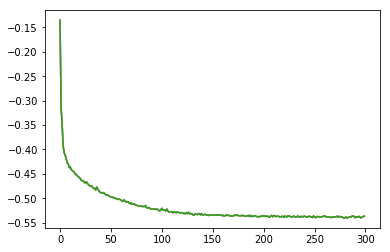

In [22]:
# summarize history for accuracy
plt.plot(history.history['loss'])
#plt.plot(history.history['val dice coef'])
plt.show()
